In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'A2O' # Choices: ['H2Z', 'A2O', 'S2W']
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA]

In [3]:
# Load dataset
dataset_function = getattr(datasets, 'A2B')
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset apple2orange..


In [5]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/A2O.pt'
=> loaded checkpoint './models/A2O.pt' (epoch 349)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [6]:
# PGD parameters
kwargs = {
        #'criterion': ch.nn.CrossEntropyLoss(reduction='none'),
        'constraint':'2',
        'eps': 80,
        'step_size': 0.5,
        'iterations': 200,
        'do_tqdm': True,
        'targeted': True,
}

In [7]:
# Get random images from dataset
_, (img, targ) = next(data_iterator)

# Perform image-to-image translation using PGD
_, img_translated = model(img, 1 - targ, make_adv=True, **kwargs)

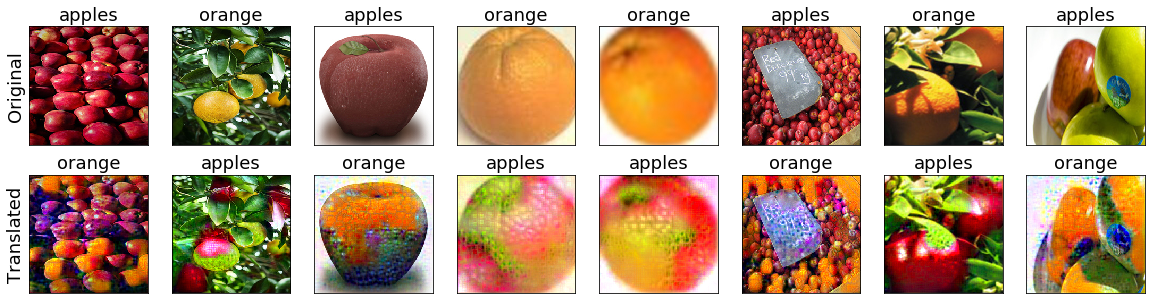

In [8]:
# Visualize image-to-image translation
show_image_row([img.cpu(), img_translated.detach().cpu()], ["Original", "Translated"], 
               tlist=[[CLASSES[int(t)] for t in targ],
                    [CLASSES[int(t)] for t in 1 - targ]],
               fontsize=18)